# Optimization in Scipy vs Tensorflow

In this notebook, we are going to compare and contrast how one would optimize a function in Scipy and in Tensorflow. Specifically, there are two general problem formulations that we want to solve:

1. $\min\limits_{x} \hspace{1ex} f(x) $
1. $\min\limits_{x} \hspace{1ex} \sum\limits_{i=1}^{N} \hspace{1ex} g(x,a_{i}) $

We will solve the first problem using both methods, and then show how to solve the second problem just with Tensorflow (although you could certainly get Scipy to do the same). 

Note that in the second case, the optimization problem typically only makes sense if $g$ is a nonnegative function. Furthermore, the second case is equivalent to the first case when 

$$ f (x) = \min\limits_{x} \hspace{1ex} \sum\limits_{i=1}^{N} \hspace{1ex} g(x,a_{i}) $$ 

However, the reason to include the second case is that this is the area where Tensorflow really shines... Specifically, when we have a large number of datapoints ($N$ is large), then just computing the cost function $f(x)$ at a single iteration may take very long, or it may even be impossible to fit into memory. In this case, we can have Tensorflow use stochastic gradient descent or one of its cousins (like ADAM) to optimize small chunks of the data at a time. 

## Problem Statement
To make this more concrete, we are going to see how to solve the basic linear regression problem 

$$ \min\limits_{x} \hspace{1ex} \sum\limits_{i=1}^{N} \hspace{1ex} \Big[ a_{i} x - b_{i} \Big]^2 $$

in Scipy and Tensorflow. We choose this problem because it can easily be written in both of the above forms:

In [1]:
import numpy

def cost( y ):
    return numpy.square(y)

def g( x, a, b ):
    return cost( numpy.dot( a, x ) - b )

def f( x, A, B ):
    return numpy.sum( ( g(x,a,b) for a, b in zip( A, B ) ) )[0]

def f_batch( x, A, B ):
    return numpy.sum( numpy.square( numpy.dot( A, x ) - B ) )

> Note that in the above formulation, $a_i$ and $b_i$ denote the $i^{th}$ rows of $A$ and $B$, respectively.

Next, we need to create the data that we will be optimizing (that is, the $A$ and $B$ matrices), along with the initial guess $x_0$ that we will use when optimizing. We aren't working from a real problem, so we are going to just randomly generate this data:

In [2]:
N  = 1000                       # Number of samples
n  = 4                          # Dimension of the optimization variable
numpy.random.seed(0)            # A seed for the random number generator so that results are reproduceable
A  = numpy.random.randn( N, n )
B  = numpy.random.randn( N, 1 )
x0 = numpy.random.randn( n, 1 )

# Just for fun, let's see what our cost function looks like at that initial guess:
print( "f(x0) :", f( x0, A, B ) )

f(x0) : 4429.67615714


## Scipy

Before even getting to Tensorflow, we can try one of Scipy's optimization solvers to see what the solution is, and how fast we can expect to solve a problem like this. 

> I don't want to dwell on this, or go into detail here because this is how optimizers work in most programming languages, and I assume you have the appropriate background. 

In [3]:
import scipy, time
from scipy.optimize import minimize

# Create the function that we want to optimize with the coefficients embedded 
func = lambda x : f( x, A, B )

# Now optimize the function, recording how long the optimization took
startTime = time.time()
solution = scipy.optimize.minimize( func, x0 )
endTime = time.time()

# This optimization method returns a lot of information. 
# We just want the optimized values
x = solution.x
print("  N  : ", N )
print("  x  : ", x )
print("f(x) : ", func(x) )
print( round(endTime - startTime, 4), "seconds to minimize using Scipy")

  N  :  1000
  x  :  [ 0.00350606  0.02388739  0.03444886  0.00796708]
f(x) :  994.699061197
0.4176 seconds to minimize using Scipy


So that is how you would typically solve an optimization problem using Scipy's solvers. Is this good? bad? Let's not dwell on that right now. Suffice it to say that we have not tuned the optimization method, tolerances, or anything, so I would expect that you could get Scipy to run better simply by choosing some of the optimization parameters more carefully. 


## Tensorflow
Now, let's see how you would do that with Tensorflow... Just so you don't get discouraged, note that this is a bit more involed. But hang with me here...

> Also, note that we are going to tackle optimizing the monolithic problem $f(x)$ first, before moving on how to use stochastic gradient descent. 

To work with Tensorflow, we need to explictly declare which objects are constants and which objects are variables (and hence subject to optimization). 

In [4]:
import tensorflow as tf 

# Declare which objects are variables, and which objects are constant
X = tf.Variable( x0 ) # Variables will be tuned by the optimizer
C = tf.constant( A )  # Constants will not be tuned by the optimizer
D = tf.constant( B )

The first problem that arises is that we can't simply substitute Tensorflow variables and constants into most python functions. Most of the basic python operations are supported by Tensorflow, but operations involving iteration typically aren't:

In [5]:
# Let's see if Tensorflow can evaluate our cost, or whether it will throw an error
try:
    print( f( X, C, D ) )
except Exception as e:
    print("Error: ", e)
    
# What about the batch formulation? 
try:
    print( f_batch( X, C, D ) )
except Exception as e:
    print("Error: ", e)

Error:  zip argument #1 must support iteration
Error:  Dimensions must be equal, but are 1000 and 4 for 'mul' (op: 'Mul') with input shapes: [1000,4], [4,1].


So we are left with two choices: 

1. Either we rewrite our code, or 
1. We wrap our function with a `py_func`

### Rewriting the optimization function with intrinsic Tensorflow methods

Depending on how large your function is, it is typically preferrable to rewrite your cost function in terms of Tensorflow functions instead of Numpy functions and iterable operations. The reason is simply that the resulting code will be more performant. So let's see how that would look for our simple example:

In [6]:
# This is our original function f written using Tensorflow operations
def f_batch_tensorflow( x, A, B ):
    e = tf.matmul( A, x ) - B
    return tf.reduce_sum( tf.square(e) )

fx = f_batch_tensorflow( X, C, D )
print(fx)

Tensor("Sum:0", shape=(), dtype=float64)


Now if you look at the output of the above code, you see that we don't have any errors. However, one glaring thing should be leaping off the page at this point... 

*Although we can now use these Tensorflow variables and constants in functions, the output of a function is no longer a value, but an expression for the output value. To actually see what the output value is, we need to evaluate the expression in a **session**.*

In [7]:
# So far we have an object 'fx' that represents the output of the function f_tensorflow. 
# To get the value of that object, we need to evaluate it in a session
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    print( "f(x0) :", sess.run( fx ), "according to Tensorflow" )

f(x0) : 4429.67615714 according to Tensorflow


> A frequent source of error is the forgetting to call "global_variables_initializer". The purpose of this call is simply to copy varriables from your python workspace into the Tensorflow space, and (as the name implies) initialize all of our variables. 

Great. But we still haven't optimized anything. To do that, we have to choose an optimizer, pass our function that we want to optimize, and then run the optimizer in a session. 

> To see all of the optimizers available to you, I suggest you take a look at https://www.tensorflow.org/api_docs/python/tf/train. Some options are the AdadeltaOptimizer, AdagradOptimizer, AdamOptimizer, FtrlOptimizer, GradientDescentOptimizer, and MomentumOptimizer (to name a few).

In [8]:
optimizer = tf.train.AdamOptimizer().minimize(fx)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print( sess.run( optimizer ) )

None


Well that is a little confusing... We run the optimizer and we get out a `None` value. Shouldn't we be getting the result? 

No. 

Calling `sess.run( optimizer )` runs the optimizer, which updates the variables in the optimization problem (in our case, just `X`). If we want to retrieve the current value of `X`, we need to run that in a session too...

In [9]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run( optimizer )
    print("  N  : ", N )
    print("  x  : ", sess.run( X ).T )
    print("f(x) : ", sess.run( fx ) )

  N  :  1000
  x  :  [[ 0.30872382 -0.73645619 -1.53591988 -0.56125483]]
f(x) :  4423.36732558


Now let's compare with the output of Scipy... Scipy, returned the solution

      N  : 1000
      x  :  [ 0.00350609  0.02388733  0.0344488   0.00796714]
    f(x) :  994.699061197
    
which is much much smaller than the cost that we got. So what gives? 

The thing about Tensorflow is that it is designed for large datasets where the optimization can take very long. Therefore the optimizers only perform one iteration at a time. It is intended that you monitor how the loss function and parameter vector $X$ change at each iteration, and then decide for yourself when to stop the optimization. Let's set up some of the usual stopping conditions. Specifically, we are going to stop if:

1. The number of iterations exceeds some predefined limit
1. The change in the cost function is less than some predefined value

In [10]:
# Reset the optimization variable here so that we start the optimization from the same starting point
X = tf.Variable( x0 )

# Put a wrapper around tensorflow that will handle the stopping conditions
def tf_minimize( func, output = None, costTol = 1e-4, maxIts = 10000, blockSize = 100, learning_rate = None, device = 'gpu' ):

    cost    = 1e10
    oldcost = cost + 2 * costTol
    its     = 0
    with tf.Session() as sess:
        with tf.device('/' + device + ':0'):

            # Now create the optimizer
            if learning_rate:
                optimizer = tf.train.AdamOptimizer(learning_rate).minimize(func)
            else: 
                optimizer = tf.train.AdamOptimizer().minimize(func)

            # Initialize all of the variables in the tensorflow workspace
            sess.run(tf.global_variables_initializer())

            # Now look, checking that we haven't hit the stopping conditions
            while cost < oldcost and oldcost - cost > costTol and its < maxIts:
                for i in range(blockSize):
                    sess.run( optimizer )
                oldcost = cost
                cost = sess.run(func)
                its += blockSize

            if output:
                return cost, sess.run( output ), its
            else:
                return cost, its
            
# Run the optimizer
startTime = time.time()
costx, x, its = tf_minimize( fx, output = X )
endTime = time.time()
print("  N  : ", N )
print("  x  : ", x.T )
print("f(x) : ", costx )
print( round(endTime - startTime, 4 ), "seconds to minimize using Tensorflow")

  N  :  1000
  x  :  [[ 0.30972382 -0.73745619 -1.53691988 -0.56225483]]
f(x) :  994.699085995
2.0726 seconds to minimize using Tensorflow


So slower than Scipy out of the gate? 

Well not so fast... 

Part of the problem here is that Tensorflow's optimizers are relatively dumb. They are performing some optimization that is only marginally smarter than gradient descent, so you have to give them a little bit of help. Specifically, when you create the optimizer, you set a fixed learning rate that is baked into the optimizer. Furthermore, this default learning rate appears to be too small for the problem at hand. If we just increase that learning rate a little bit, we see performance much closer to Scipy:

In [11]:
# Run the optimizer with a larger learning rate
startTime = time.time()
costx, x, its = tf_minimize( fx, output = X, learning_rate = 1 )
endTime = time.time()
print("  N  : ", N )
print("  x  : ", x.T )
print("f(x) : ", costx )
print( round(endTime - startTime, 4 ), "seconds to minimize using Tensorflow")

  N  :  1000
  x  :  [[ 0.30972382 -0.73745619 -1.53691988 -0.56225483]]
f(x) :  994.699061197
0.2589 seconds to minimize using Tensorflow


### Larger Datasets

Next, for the sake of argument, let's try increasing the size of the dataset and reoptimizing:

In [12]:
Nnew  = N * 10                  # Number of samples
nnew  = n * 1                   # Dimension of the optimization variable
numpy.random.seed(0)            # A seed for the random number generator so that results are reproduceable
A  = numpy.random.randn( Nnew, nnew )
B  = numpy.random.randn( Nnew, 1 )
x0 = numpy.random.randn( nnew, 1 )

# Scipy
func = lambda x : f( x, A, B )
startTime = time.time()
solution = scipy.optimize.minimize( func, x0 )
endTime = time.time()
x = solution.x
print("  x  : ", x )
print("f(x) : ", func(x) )
print( round(endTime - startTime, 4), "seconds to minimize using Scipy")
print()

# Tensorflow
X = tf.Variable( x0 )
C = tf.constant( A )
D = tf.constant( B )
fx = f_batch_tensorflow( X, C, D )

startTime = time.time()
costx, x, its = tf_minimize( fx, output = X, learning_rate = 1 )
endTime = time.time()
print("  x  : ", x.T )
print("f(x) : ", costx )
print( round(endTime - startTime, 4 ), "seconds to minimize using Tensorflow")

  x  :  [ 0.02021202 -0.00563212  0.01110649  0.00634589]
f(x) :  9921.52770949
12.6023 seconds to minimize using Scipy

  x  :  [[ 0.02021196 -0.00563217  0.01110651  0.00634575]]
f(x) :  9921.52770949
0.2728 seconds to minimize using Tensorflow


Curiously, the runtime for Scipy is scaling with the size of the dataset, but the Tensorflow runtime remains flat. Awesome. 

> Note that your mileage will vary here depending on whether you are using a CPU or GPU, and the performance of your device.

## Tensorflow with native Python methods

At this point, you might be thinking that this all looks well and good, but you don't want to modify your functions just so that you can optimize them with Tensorflow... Well, if that is you, then I have good news... you don't have to. 

First, I will introduce a utility method. You do not have to understand what exactly is going on here, but suffice it to say that it is converting a Python function into one that can be used directly by Tensorflow. The caveat is that the function you want o convert must return both the function value and its Jacobian:

In [13]:
from tensorflow.python.framework import ops
import time

def toTensorflow(func, x, name, dtype=tf.float64, stateful=False):
    '''
    :param func: A function that returns its value and the gradient.
    '''
    # Generate a unique name
    gradient_name = 'gradient' + str(time.time())

    with ops.name_scope(None, name, [x]) as name:
        
        # Create a lambda that returns the gradient, and then register it
        grad = lambda op, grad, grad_grad: grad * op.outputs[1]
        tf.RegisterGradient(gradient_name)(grad)

        # Finally, wrap our function with in a py_func
        with tf.get_default_graph().gradient_override_map({"PyFunc": gradient_name, "PyFuncStateless": gradient_name}):
            return tf.py_func(func, [x], [dtype, dtype], stateful=stateful, name=name)[0]

So, for instance, we previously optimized the function `f` in Scipy, but we showed that we couldn't evaluate the expression in Tensorflow. We are going to remedy that here. 

First, we need to define a function that returns the cost as well as the derivative of the cost:

In [14]:
def f_df( x, A, B ):
    e = numpy.dot(A, x) - B
    return numpy.sum( numpy.square(e) ), numpy.dot(A.T, e)

With that out of the way, we can now convert our Python function to Tensorflow and run it directly:

In [15]:
def convert_and_run(func_with_gradients, maxits = 10000):

    # Reset the optimization variable
    X = tf.Variable( x0 )

    # Now convert the function to be comptabile with tensorflow
    f_tensorflow = toTensorflow( func_with_gradients, X, "my_cost" )

    # Run the optimizer
    startTime = time.time()
    costx, x, its = tf_minimize( f_tensorflow, output = X, learning_rate = 1 )
    endTime = time.time()
    print("  x  : ", x.T )
    print("f(x) : ", costx )
    print( round(endTime - startTime, 4 ), "seconds to minimize using Tensorflow")

convert_and_run( lambda x : f_df( x, A, B ) )

  x  :  [[ 0.02021196 -0.00563217  0.01110651  0.00634575]]
f(x) :  9921.52770949
0.3915 seconds to minimize using Tensorflow


### Look mom, no gradients!

Perhaps these results are a bit surprsing. Perhaps not. But everybody that has worked with optimization before knows that an absolute deal-breaker in the above code is that it requires that we know the gradient of the cost function. This is not so easy for most problems. 

The work-around, as with most optimization scenarios, is to see if we can drop in numerical differentiation as a replacement. And sure enough, after Googling around, it seems that there are two python functions that are commonly used:

1. `numdifftools.core.Jacobian`
1. `scipy.optimize.approx_fprime`

Let's try both of those:

In [16]:
from numdifftools.core import Jacobian
from scipy.optimize import approx_fprime

func = lambda x : numpy.sum( ( numpy.dot( A, x ) - B )**2 )

j1 = lambda x : Jacobian( func )(x).reshape( x.shape )

epsilon = numpy.sqrt(numpy.finfo(float).eps)
j2 = lambda x : approx_fprime(x, func, epsilon ).reshape( x.shape )

print("numdifftools.core.Jacobian  : \n", j1(x0))
print("-------------")
print("scipy.optimize.approx_fprime: \n", j2(x0)) # Something is really wrong here 
print("-------------")

numdifftools.core.Jacobian  : 
 [[  1326.69931344]
 [ 33261.25106713]
 [-32605.07592774]
 [-12598.00613771]]
-------------
scipy.optimize.approx_fprime: 
 [[  1.38295899e+13]
 [  1.38295899e+13]
 [  1.38295899e+13]
 [  1.38295899e+13]]
-------------


I am not sure exactly what is going on here, but the Scipy output looks just wrong. The Jacobian shouldn't just be a really large constant vector. 

On the other hand, the numdifftool Jacobians appear reasonable, so let's try optimizing with those: 

In [17]:
convert_and_run( lambda x : ( func(x), j1(x) ) )

  x  :  [[ 0.02021196 -0.00563217  0.01110651  0.00634575]]
f(x) :  9921.52770949
3.3698 seconds to minimize using Tensorflow


Nice... a working example using Tensorflow with some numerical differentiation scheme. Of course we take a performance hit here, but at least we get the same output, and we don't have to know the Jacobian *a priori*.

### Automatic differentiation

The last thing I want you to ponder here is why we need to explictly provide a gradient to Tensorflow. In the pure-Tensorflow implementation, we didn't need to provide gradients, so why do we need to do it now? 

The answer is simply that Tensorflow DOES require gradients. In fact, it is a core part of how Tensorflow works. However, when you build a Tensorflow function, behind the scenes, it is also building a function that computes its derivative. You could think of it as a symbolic representation that is being built as you compile your function. That way, when we run our function, the gradients are computed explictly, without having to resort to numerical differentiation. 

So the question is... can we do something like that with our pure-python code? 

Fortunately, there is a package `autograd` that does this for you, as long as you are using numpy functions (which is commonly the case). The catch (and this is very important to get the code working at full speed), is that you need to import numpy from `autograd`... 

In [18]:
from autograd import numpy as autograd_numpy
from autograd import grad

func = lambda x : autograd_numpy.sum( autograd_numpy.square( autograd_numpy.dot( A, x ) - B ) )
jacob = grad(func)
convert_and_run( lambda x : ( func(x), jacob(x) ) )

  x  :  [[ 0.02021196 -0.00563217  0.01110651  0.00634575]]
f(x) :  9921.52770949
0.4651 seconds to minimize using Tensorflow


Again, we should not expect this work as fast as the pure Tensorflow code, but we should be able to get pretty close because this code is NOT doing numerical differentiation. Rather, we have created a precompiled expression for the jacobian of our function.  

## Big Data

Hopefully by now you have some feel for how you might use Tensorflow to optimize some monolithic problem. Now let's look at how you would deal with a problem that is simply too big to fit in memory. 

Specifically, recall that we are trying to solve the regression problem

$$\min\limits_{x} \hspace{1ex} \left\| A x - B \right\|^2 $$

which can be written as 

$$\min\limits_{x} \hspace{1ex} \sum\limits_{i=1}^{N} \hspace{1ex} \left( a_{i} x - b_{i} \right)^2 $$

where $a_{i}$ and $b_{i}$ denote the $i^{th}$ rows of some matrices $A$ and $B$. Or more generally, you could say we are trying to solve 

$$\min\limits_{x} \hspace{1ex} \sum\limits_{i=1}^{N} \hspace{1ex} g(x,a_{i}) $$

The problem is that as we get more and more data, eventually we won't be able to fit it all into memory. That means that we won't be able to use Scipy or Tensorflow to optimize this function using the techniques that we previously presented. Instead, we will have to use *stochastic gradient descent*, which is widely used in the machine learning community. Here are the core principles:

* We can't fit all of the data into memory, so we will break the data up from one monolithic problem of size `N` into `p` smaller problems of size $<=$`batch_size`, where `p = N / batch_size` (+/- 1 depending on whether `N` is divisible by `batch_size`). 
* Ideally, each of these batches is representative of the larger dataset, so that optimizing a subset moves us closer to the minimum of the entire dataset.
* We squentially solve the optimization for each of these batches, letting the optimizer keep running tallies of gradients, hessians, etc. (if it wants) between each of these solutions. Doing so lets us retain information about the whole dataset, even though we are just optimizing a subset. 
* We don't want each iteration to look the same (otherwise, the solution may just oscillate between the same values). Hence at the beginning of each iteration, we randomly shuffle the data before splitting up the problem into smaller datasets. 

> Note that although we would like to get to the global minimizer of the optimization problem, stochastic gradient descent does not do this. The reason is that for most machine learning problems, the datasets are so huge that even computing the cost over the whole dataset might take unreasonably long. Instead, the goal really is just to try to get close to a minimizer. Then, if it is possible for your problem, you could try using a method which would get you to a local minimizer from there.

In psuedocode, that leaves us with an optimization method like:

    def minimize( func, N, feeder, block_size,  batch_size ):

        with tf.Session() as sess:

            # Create the optimizer and initialize variables
            optimizer = ...
            sess.run(tf.global_variables_initializer())
            
            # Create a list of indices for the number of datapoints. We reshuffle this in each iteration
            inds = list(range(N))

            # Loop until converged
            while not converged:

                # Block size defines how many times to loop over the whole data before rechecking convergence 
                for i in range(block_size):

                    # At each iteration, shuffle the data
                    random.shuffle(inds)

                    # Batch size defines the size of the smaller optimization problems 
                    for offset in range(0, N, batch_size):
                    
                        # Presumably we have a method, feeder, which returns the required feedDict 
                        # with the data at the specified indices
                        feedDict = feeder( inds[offset:offset+batch_size] )
                        
                        # TODO... Somehow tell the optimizer to just optimize this subset of data 
                        sess.run( optimizer, feedDict )

Until now, we have explained everything you need to know to be able to implement this pseudocode EXCEPT how to create some sort of placeholder for the data so that we can just optimize over a subset of the data. 

Previously, you will note that we created our optimization functions by creating a Tensorflow constant from our raw python data. For instance, when we were using the intrinsic Tensorflow functions, we had something like:

    x0 = numpy.random.randn( n, 1 )
    A  = numpy.random.randn( N, n )
    B  = numpy.random.randn( N, 1 )
    
    X = tf.Variable( x0 )
    C = tf.constant( A )
    D = tf.constant( B )
    fx = f_batch_tensorflow( X, C, D )

The problem with this method is that it bakes those python matrices `A` and `B` directly into the function, leaving us no way of changing those values later. If we are going to be dealing with small subsets of data, and shuffle the data at each iteration, that means we would need to create millions of small optimization objects... Not very efficient. 

Fortunately, Tensorflow has a convenient construct for this particular use case, aptly called a `placeholder`. Instead of hard-coding some constants into the optimization problem, the placeholder will approximately define the shape of the object to expect in a function. The missing parameters must then be passed in to the `Session.run()` call using what is called a *feed dictionary*. Instead of describing this is words, let's see how that looks in code with a simple example: 

In [19]:
import tensorflow as tf

# Define placeholders for the matrix A and x in the product A * x
# Note that the value of `None` may only be used for one dimension, and will be inferred from the size of input
p = 4
Ap = tf.placeholder(tf.float64, shape=(None, p))
Xp = tf.placeholder(tf.float64, shape=(p, None))
AX = tf.matmul( Ap, Xp )

# At this point, AX represents a general matrix product where the inner dimension is p. 
# The other dimensions can be anything
with tf.Session() as sess:

    # Now create some "real" values to use in the matrix product. 
    # Note that the inner dimension 'p' is fixed, but the other dimensions are arbitrary
    ap = numpy.ones( (2, p) )
    xp = numpy.ones( (p, 5) )
    print( sess.run( AX, { Ap : ap, Xp : xp } ) )
    print('------------')
    
    ap = numpy.eye(p)
    xp = numpy.ones( (p, 1) )
    print( sess.run( AX, { Ap : ap, Xp : xp } ) )

[[ 4.  4.  4.  4.  4.]
 [ 4.  4.  4.  4.  4.]]
------------
[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]


Hopefully that little snippet tells you what the placeholder is doing... Now let's see how we plan to use it. 

In stochastic gradient descent, it doesn't make sense to check convergence of the cost function like before because the cost function can increase with time. Hence here we just want to run a few iterations to show you how the cost function behaves in sub-iterations, and across entire iterations.  

> We are showing the average cost per subiteration because the size of the dataset can be different in the subiterations. Specifically, the last subiteration might have less data than the others. 


> The following code is definitely not something you want to do in production. You should try to minimize the amount of data that must be copied between the CPU and GPU, and all of the logging below creates a lot of extra copies that need to be made. 

In [20]:
def tf_minimize_sgd( func, feeder, N, maxIts = 20, learning_rate = None, 
                     device = 'gpu', blockSize = 1, batch_size = 100 ):

    its = 0
    with tf.Session() as sess:
        with tf.device('/' + device + ':0'):

            # Now create the optimizer
            if learning_rate:
                optimizer = tf.train.AdamOptimizer(learning_rate).minimize(func)
            else: 
                optimizer = tf.train.AdamOptimizer().minimize(func)

            # Initialize all of the variables in the tensorflow workspace
            sess.run(tf.global_variables_initializer())

            # Create a list of indices for the number of datapoints. We reshuffle this in each iteration
            inds = list(range(N))
            
            # Sub-iteration and per-iteration costs  
            subit_costs = [] 
            it_costs    = []
            
            # Now loop, checking that we haven't hit the stopping conditions
            while its < maxIts:
                
                # Block size defines how many times to loop over the whole data 
                for i in range(blockSize):
                    
                    # At each iteration, shuffle the data
                    numpy.random.shuffle(inds)
                    
                    # Batch size defines the size of the smaller optimization problems 
                    for offset in range(0, N, batch_size):
                    
                        selection = inds[offset:offset+batch_size]
                        feedDict = feeder( selection )
                        sess.run( optimizer, feedDict )
                        subit_costs.append( sess.run( func, feedDict ) / len(selection) )
                
                    # Compute the total cost at the end of this iteration
                    cost = 0
                    for offset in range(0, N, batch_size):
                        feedDict = feeder( inds[offset:offset+batch_size] )
                        cost += sess.run( func, feedDict )
                    it_costs.append( cost / N )
                its += blockSize
            return subit_costs, it_costs

The final piece of the puzzle is to define placeholders in our regression example, and then introduce a function which generates the feed dictionaries for us. For the regression example that we have been working, that would look like: 

In [21]:
# Define placeholders for the data 
C  = tf.placeholder(tf.float64, shape=(None, A.shape[1]), name='Cmatrix')
D  = tf.placeholder(tf.float64, shape=(None, B.shape[1]), name='Bmatrix')

# Reset the optimization variable and redefine the optimization function
X = tf.Variable( x0 )
fx = f_batch_tensorflow( X, C, D )

# Create the feed dictionary generator
def feeder(inds, A, B, C, D ): 
    return { C : A[inds,:], D : B[inds,:] }

# Run the optimizer
startTime = time.time()
subit_costs, it_costs = tf_minimize_sgd( fx, feeder = lambda x : feeder( x, A, B, C, D ), N = A.shape[0], learning_rate = 1 )
endTime = time.time()
print( round(endTime - startTime, 4 ), "seconds to minimize using Tensorflow")

3.602 seconds to minimize using Tensorflow


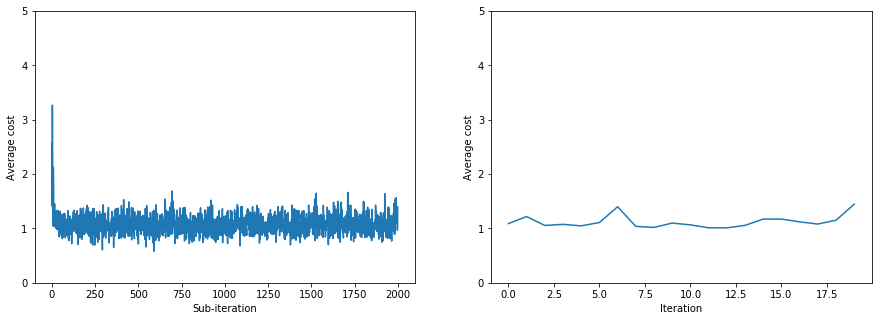

In [22]:
import matplotlib.pyplot as plt 
%matplotlib inline

fig, axes = plt.subplots( 1, 2, figsize = (15,5) );

axes[0].plot( subit_costs );
axes[0].set_xlabel("Sub-iteration");
axes[0].set_ylabel("Average cost");
axes[0].set_ylim((0,5));

axes[1].plot( it_costs );
axes[1].set_xlabel("Iteration");
axes[1].set_ylabel("Average cost");
axes[1].set_ylim((0,5));

What you can see is that after one complete iteration, the optimization seems to have reached what might be described as the "noise floor". That is, without increasing the batch sizes, we will always see this sort of oscillation about some local minimizer with stochastic gradient descent because it is never actually computing the cost function across all of the data. Hence it does a great job of getting you right up to the local minimizer, although you will need a more complete solution which computes the cost across the whole dataset to take you the last mile. 

## Summary

In this notebook, we compared Scipy's optimizers with a simple Tensorflow implementation. The point was not to do an extensive comparison, but rather, simply to get a first look into how you would optimize a function with both packages. What seems to be the case out-of-the box is that the Scipy implementation scales poorly with the size of the problem, while the Tensorflow implementation does not. However, as we show, the Scipy implementation can be used out-of-the box, while the Tensorflow implementation requires one to either rewrite their function in terms of Tensorflow intrinsics, or by providing a function along with its derivatives. In the latter case, we showed how one would do so using numerical differentiation and automatic differentiation. Finally, we showed how to use Tensorflow to ist fullest potential by showing how you would use stochastic gradient descent. 